In [1]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

import os

import numpy as np

%cd ../scripts/

/home/drfrbc/Neural-Modeling/scripts


In [2]:
sim_directory = '14-06-2024-15-57-42-HMM/Complex_Np5'
#'11-06-2024-10-23-32-FinalFExcFR/Complex_Np10'
#'11-06-2024-09-52-42-FinalFExcFR'
#'09-06-2024-15-50-55-TestingPCsSta/Complex_Np5'#'05-06-2024-14-19-43-Full120Sec/Complex_Np5'
# sim_directory = sim.path

In [3]:
# # plot vm around dend spikes
# %matplotlib inline
# plot_command = f"python3 plot_vm_for_dend_spikes.py -d {sim_directory}/Branches_Np5 -s"
# os.system(plot_command)

In [4]:
import analysis
from logger import Logger
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
import os
import traceback
import random


def plot_voltage_for_segments_where_spikes_occur(
    seg_data,
    v,
    soma_spikes,
    dend_spike_start_times,
    title,
    section,
    min_time_index=0,
    max_time_index=2000,
    time_indices_before_soma_spike=50,
    time_indices_after_soma_spike=50,
    max_soma_spikes_plotted=1,
    max_segments_with_dend_spikes_per_soma_spike=100,
    save=True,
    sim_directory='',
    include_legend=True,
    use_varied_colors=True):
    """
    Plots voltage for segments where spikes occur.

    Parameters:
    ... [other parameters] ...
    include_legend : bool, optional
        Include a legend in the plot to identify segment indices.
    use_varied_colors : bool, optional
        Use varied colors for dendritic voltages.
    """

    if title == 'Ca':
        indexes = seg_data[(seg_data["section"] == "apic")].index
    else:
        indexes = seg_data[(seg_data["section"] == section)].index
        
    print(seg_data.keys())
    print(f"{title+section} indexes: {indexes}")

    fig, ax = plt.figure(figsize=(15, 10)), plt.gca()

    # Generate a list of distinct colors if varied colors are to be used
    if use_varied_colors:
        palette_name = 'tab20'
        colors = list(plt.get_cmap(palette_name).colors)  # Convert to list before shuffling
        random.shuffle(colors)
    # Randomly select soma spikes, respecting the maximum limit
    random_soma_spikes = random.sample(list(soma_spikes[0][1:-1]), min(len(soma_spikes[0][1:-1]), max_soma_spikes_plotted))

    for soma_spike in random_soma_spikes:
        min_index = int(max(soma_spike - time_indices_before_soma_spike, 0))
        max_index = int(min(soma_spike + time_indices_after_soma_spike, len(v[0])))

        # Check if the range around the soma spike is sufficient
        if (max_index - min_index) != (time_indices_before_soma_spike + time_indices_after_soma_spike):
            continue

        eligible_segments = []
        for seg_index in indexes:
            seg_dend_spikes = dend_spike_start_times[seg_index]
            if any(min_index < spike_time < max_index for spike_time in seg_dend_spikes):
                eligible_segments.append(seg_index)

        # Randomly select segments to plot, respecting the maximum limit
        segments_to_plot = random.sample(eligible_segments, min(len(eligible_segments), max_segments_with_dend_spikes_per_soma_spike))

    for i, seg_index in enumerate(segments_to_plot):
        seg_dend_spikes = dend_spike_start_times[seg_index]
        color = colors[i % len(colors)] if use_varied_colors else 'blue'
        ax.plot(v[seg_index][min_index:max_index], color=color, linewidth=0.25, label=f'Segment {seg_index}' if use_varied_colors else None)
        for spike_time in seg_dend_spikes:
            if min_index < spike_time < max_index:
                spike_label = 'Dendritic Spike' if f'Dendritic Spike' not in ax.get_legend_handles_labels()[1] else None
                ax.plot(spike_time - min_index, v[seg_index][spike_time], '*', markersize=10, color=color, label=spike_label)
    
    if len(segments_to_plot) > 0:
        ax.plot(v[0][min_index:max_index], color='black', linewidth=1.0, label='Soma')
        soma_spike_label = 'Somatic Spike' if 'Somatic Spike' not in ax.get_legend_handles_labels()[1] else None
        ax.plot(soma_spike - min_index, max(v[0][min_index:max_index]), '*', markersize=10, color='black', label=soma_spike_label)
    
    ax.set_title('Vm ' + title + section)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel("Voltage")
    
    if include_legend:
        ax.legend()

    plt.show(fig)

    if save:
        fig.savefig(os.path.join(sim_directory, f"Vm_{title+'_'+section}.png"), dpi=fig.dpi)
    

In [5]:
# soma_spikes

In [6]:
# list(soma_spikes[0][1:-1]), min(len(soma_spikes[0][1:-1]), max_soma_spikes_plotted)

--No graphics will be displayed.


Index(['Unnamed: 0', 'section', 'idx_in_section_type', 'seg_half_seg_RA', 'L',
       'seg', 'pseg', 'p0_0', 'p0_1', 'p0_2', 'pc_0', 'pc_1', 'pc_2', 'p1_0',
       'p1_1', 'p1_2', 'r', 'dl_0', 'dl_1', 'dl_2'],
      dtype='object')
NMDAdend indexes: Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262],
      dtype='int64', length=262)


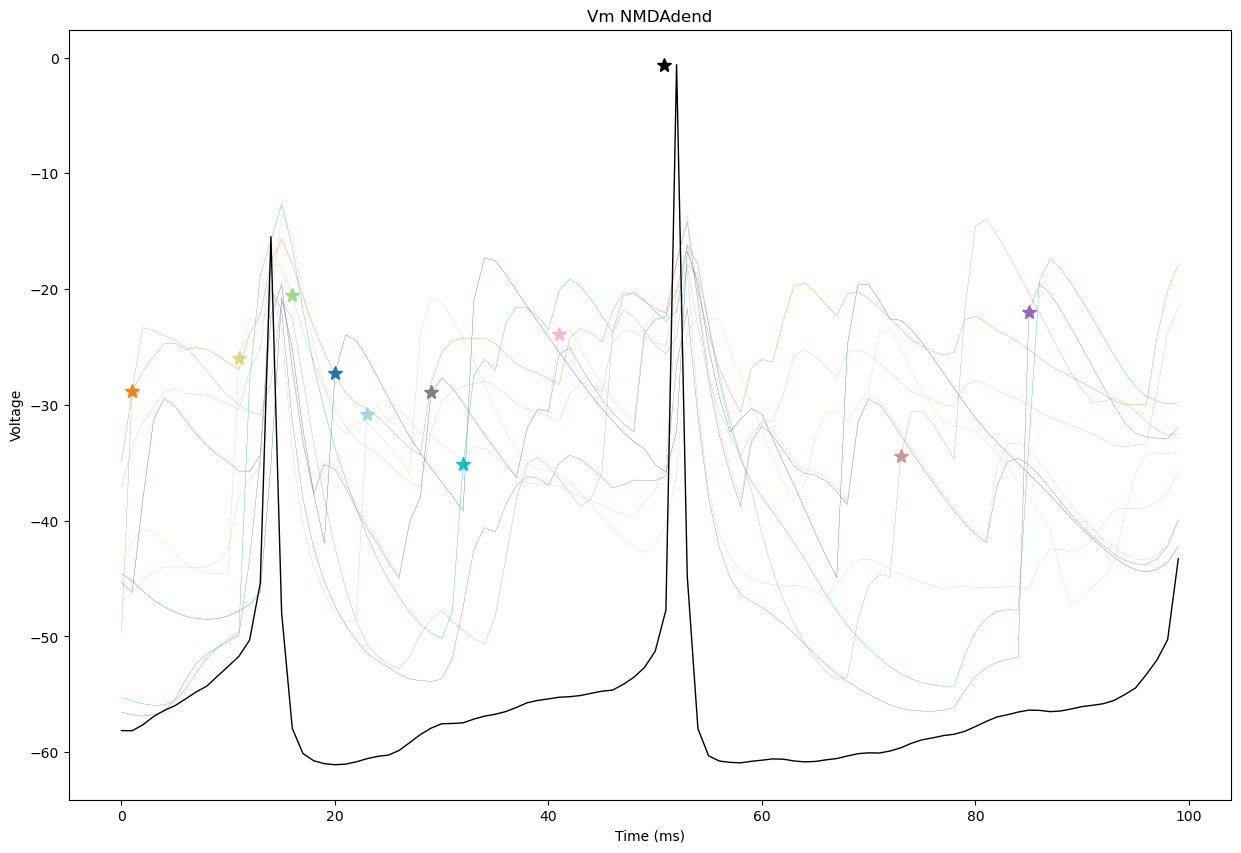

In [7]:
soma_spikes = analysis.DataReader.read_data(sim_directory, "soma_spikes")
parameters = analysis.DataReader.load_parameters(sim_directory)

seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))
#indexes = seg_data[(seg_data["section"] == "apic") | (seg_data["section"] == "dend")].index

v = analysis.DataReader.read_data(sim_directory, "v")
inmda = analysis.DataReader.read_data(sim_directory, "i_NMDA")

NMDA_spikes = []
for i in range(len(v)):#for i in indexes:
    left_bounds, _, _ = analysis.VoltageTrace.get_NMDA_spikes(v[i], -40, inmda[i])
    NMDA_spikes.append(left_bounds)

title='NMDA'
section = 'dend'
use_varied_colors = True
time_indices_before_soma_spike = 50
time_indices_after_soma_spike=50
max_soma_spikes_plotted=10
max_segments_with_dend_spikes_per_soma_spike=10
dend_spike_start_times=NMDA_spikes

if title == 'Ca':
    indexes = seg_data[(seg_data["section"] == "apic")].index
else:
    indexes = seg_data[(seg_data["section"] == section)].index
    
print(seg_data.keys())
print(f"{title+section} indexes: {indexes}")

fig, ax = plt.figure(figsize=(15, 10)), plt.gca()

# Generate a list of distinct colors if varied colors are to be used
if use_varied_colors:
    palette_name = 'tab20'
    colors = list(plt.get_cmap(palette_name).colors)  # Convert to list before shuffling
    random.shuffle(colors)
# Randomly select soma spikes, respecting the maximum limit
random_soma_spikes = random.sample(list(soma_spikes[0][1:-1]), min(len(soma_spikes[0][1:-1]), max_soma_spikes_plotted))

for soma_spike in random_soma_spikes:
    min_index = int(max(soma_spike - time_indices_before_soma_spike, 0))
    max_index = int(min(soma_spike + time_indices_after_soma_spike, len(v[0])))

    # Check if the range around the soma spike is sufficient
    if (max_index - min_index) != (time_indices_before_soma_spike + time_indices_after_soma_spike):
        continue

    eligible_segments = []
    for seg_index in indexes:
        seg_dend_spikes = dend_spike_start_times[seg_index]
        if any(min_index < spike_time < max_index for spike_time in seg_dend_spikes):
            eligible_segments.append(seg_index)

    # Randomly select segments to plot, respecting the maximum limit
    segments_to_plot = random.sample(eligible_segments, min(len(eligible_segments), max_segments_with_dend_spikes_per_soma_spike))

for i, seg_index in enumerate(segments_to_plot):
    seg_dend_spikes = dend_spike_start_times[seg_index]
    color = colors[i % len(colors)] if use_varied_colors else 'blue'
    ax.plot(v[seg_index][min_index:max_index], color=color, linewidth=0.25, label=f'Segment {seg_index}' if use_varied_colors else None)
    for spike_time in seg_dend_spikes:
        if min_index < spike_time < max_index:
            spike_label = 'Dendritic Spike' if f'Dendritic Spike' not in ax.get_legend_handles_labels()[1] else None
            ax.plot(spike_time - min_index, v[seg_index][spike_time], '*', markersize=10, color=color, label=spike_label)

if len(segments_to_plot) > 0:
    ax.plot(v[0][min_index:max_index], color='black', linewidth=1.0, label='Soma')
    soma_spike_label = 'Somatic Spike' if 'Somatic Spike' not in ax.get_legend_handles_labels()[1] else None
    ax.plot(soma_spike - min_index, max(v[0][min_index:max_index]), '*', markersize=10, color='black', label=soma_spike_label)

ax.set_title('Vm ' + title + section)
ax.set_xlabel('Time (ms)')
ax.set_ylabel("Voltage")

# if include_legend:
#     ax.legend()

plt.show(fig)

# if save:
#     fig.savefig(os.path.join(sim_directory, f"Vm_{title+'_'+section}.png"), dpi=fig.dpi)

#compute and plot
# plot_voltage_for_segments_where_spikes_occur(seg_data, v, soma_spikes, NMDA_spikes, 'NMDA',section='dend')
# plot_voltage_for_segments_where_spikes_occur(seg_data, v, soma_spikes, NMDA_spikes, 'NMDA',section='apic')

Index(['Unnamed: 0', 'section', 'idx_in_section_type', 'seg_half_seg_RA', 'L',
       'seg', 'pseg', 'p0_0', 'p0_1', 'p0_2', 'pc_0', 'pc_1', 'pc_2', 'p1_0',
       'p1_1', 'p1_2', 'r', 'dl_0', 'dl_1', 'dl_2'],
      dtype='object')
NMDAdend indexes: Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262],
      dtype='int64', length=262)


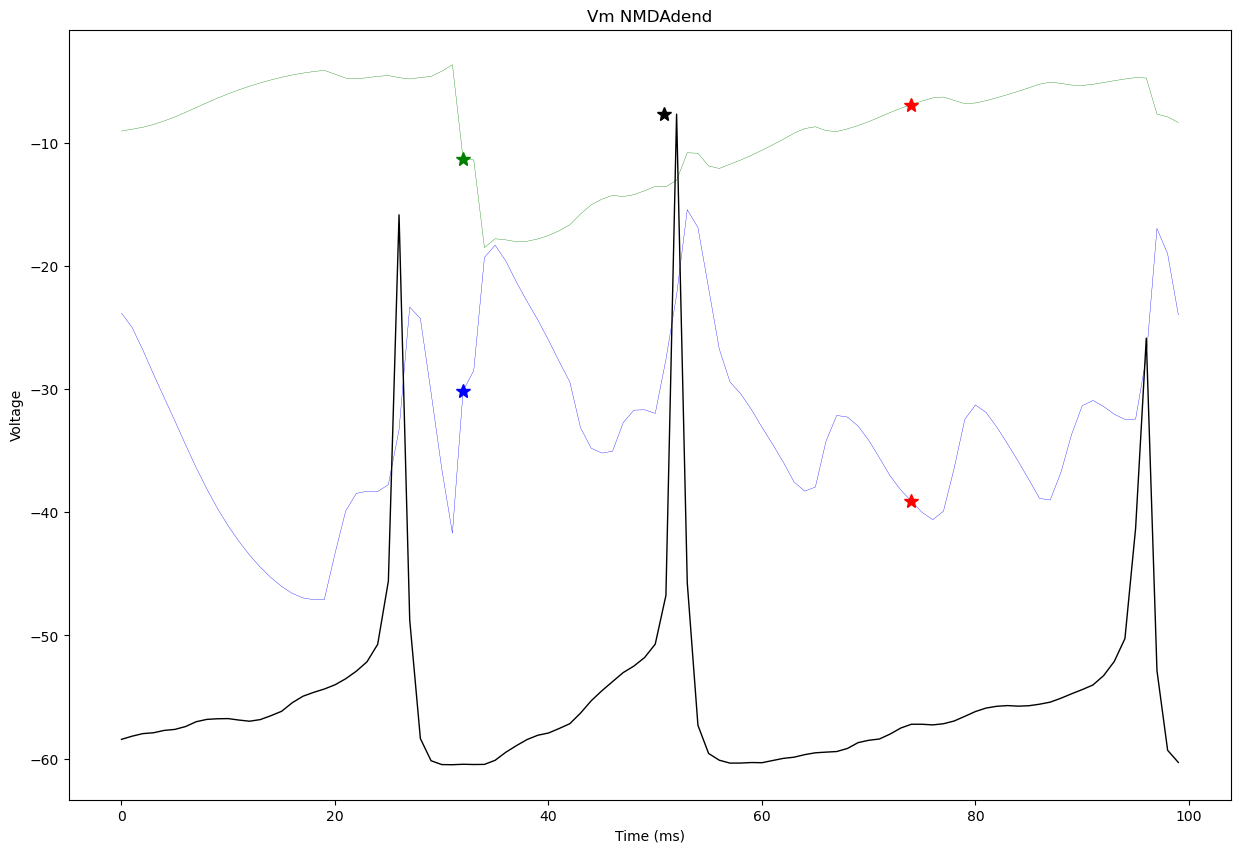

In [8]:
soma_spikes = analysis.DataReader.read_data(sim_directory, "soma_spikes")
parameters = analysis.DataReader.load_parameters(sim_directory)

seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))
#indexes = seg_data[(seg_data["section"] == "apic") | (seg_data["section"] == "dend")].index

v = analysis.DataReader.read_data(sim_directory, "v")
inmda = analysis.DataReader.read_data(sim_directory, "i_NMDA")

NMDA_spikes = []
NMDA_spikes_ends = []
for i in range(len(v)):#for i in indexes:
    left_bounds, right_bounds, _ = analysis.VoltageTrace.get_NMDA_spikes(v[i], -40, inmda[i])
    NMDA_spikes.append(left_bounds)
    NMDA_spikes_ends.append(right_bounds)

title='NMDA'
section = 'dend'
use_varied_colors = True
time_indices_before_soma_spike = 50
time_indices_after_soma_spike=50
max_soma_spikes_plotted=10
max_segments_with_dend_spikes_per_soma_spike=1#10
dend_spike_start_times=NMDA_spikes
dend_spike_end_times=NMDA_spikes_ends

if title == 'Ca':
    indexes = seg_data[(seg_data["section"] == "apic")].index
else:
    indexes = seg_data[(seg_data["section"] == section)].index
    
print(seg_data.keys())
print(f"{title+section} indexes: {indexes}")

fig, ax = plt.figure(figsize=(15, 10)), plt.gca()

# Generate a list of distinct colors if varied colors are to be used
if use_varied_colors:
    palette_name = 'tab20'
    colors = list(plt.get_cmap(palette_name).colors)  # Convert to list before shuffling
    random.shuffle(colors)
# Randomly select soma spikes, respecting the maximum limit
random_soma_spikes = random.sample(list(soma_spikes[0][1:-1]), min(len(soma_spikes[0][1:-1]), max_soma_spikes_plotted))

for soma_spike in random_soma_spikes:
    min_index = int(max(soma_spike - time_indices_before_soma_spike, 0))
    max_index = int(min(soma_spike + time_indices_after_soma_spike, len(v[0])))

    # Check if the range around the soma spike is sufficient
    if (max_index - min_index) != (time_indices_before_soma_spike + time_indices_after_soma_spike):
        continue

    eligible_segments = []
    for seg_index in indexes:
        seg_dend_spikes = dend_spike_start_times[seg_index]
        seg_dend_spikes_ends = dend_spike_end_times[seg_index]
        if any(((min_index < spike_time < max_index) and (min_index < seg_dend_spikes_ends[i] < max_index)) for i,spike_time in enumerate(seg_dend_spikes)) :
            eligible_segments.append(seg_index)

    # Randomly select segments to plot, respecting the maximum limit
    segments_to_plot = random.sample(eligible_segments, min(len(eligible_segments), max_segments_with_dend_spikes_per_soma_spike))

for i, seg_index in enumerate(segments_to_plot):
    seg_dend_spikes = dend_spike_start_times[seg_index]
    seg_dend_spikes_ends = dend_spike_end_times[seg_index]
    color = colors[i % len(colors)] if use_varied_colors else 'blue'
    ax.plot(v[seg_index][min_index:max_index], color='blue', linewidth=0.25, label=f'Segment {seg_index}' if use_varied_colors else None)
    ax.plot(inmda[seg_index][min_index:max_index]*2000, color='green', linewidth=0.25, label=f'Segment {seg_index}' if use_varied_colors else None)
    for j,spike_time in enumerate(seg_dend_spikes):
        spike_end_time = seg_dend_spikes_ends[j]
        if min_index < spike_time < max_index:
            spike_label = 'Dendritic Spike' if f'Dendritic Spike' not in ax.get_legend_handles_labels()[1] else None
            ax.plot(spike_time - min_index, v[seg_index][spike_time], '*', markersize=10, color='blue', label=spike_label)
            ax.plot(spike_time - min_index, inmda[seg_index][spike_time]*2000, '*', markersize=10, color='green', label=spike_label)
        if min_index < spike_end_time < max_index:
            ax.plot(spike_end_time - min_index, v[seg_index][spike_end_time], '*', markersize=10, color='red', label=spike_label)
            ax.plot(spike_end_time - min_index, inmda[seg_index][spike_end_time]*2000, '*', markersize=10, color='red', label=spike_label)

if len(segments_to_plot) > 0:
    ax.plot(v[0][min_index:max_index], color='black', linewidth=1.0, label='Soma')
    soma_spike_label = 'Somatic Spike' if 'Somatic Spike' not in ax.get_legend_handles_labels()[1] else None
    ax.plot(soma_spike - min_index, max(v[0][min_index:max_index]), '*', markersize=10, color='black', label=soma_spike_label)

ax.set_title('Vm ' + title + section)
ax.set_xlabel('Time (ms)')
ax.set_ylabel("Voltage")

# if include_legend:
#     ax.legend()

plt.show(fig)

# if save:
#     fig.savefig(os.path.join(sim_directory, f"Vm_{title+'_'+section}.png"), dpi=fig.dpi)

#compute and plot
# plot_voltage_for_segments_where_spikes_occur(seg_data, v, soma_spikes, NMDA_spikes, 'NMDA',section='dend')
# plot_voltage_for_segments_where_spikes_occur(seg_data, v, soma_spikes, NMDA_spikes, 'NMDA',section='apic')

In [9]:
NMDA_spikes = []
NMDA_spikes_ends = []
durations = []
for i in range(len(v)):#for i in indexes:
    left_bounds, right_bounds, _ = analysis.VoltageTrace.get_NMDA_spikes(v[i], -40, inmda[i])
    NMDA_spikes.append(left_bounds)
    NMDA_spikes_ends.append(right_bounds)
    for j in range(len(left_bounds)):
        durations.append(right_bounds[j]-left_bounds[j])

In [10]:
NMDA_spikes_ends                 

[[],
 [],
 [],
 [],
 [],
 [],
 [12741, 23807, 27675],
 [65,
  257,
  7273,
  8020,
  10540,
  10991,
  12464,
  15513,
  16877,
  19372,
  19409,
  21121,
  23134,
  23275,
  24038,
  26042,
  26421,
  26536,
  27678,
  29001,
  29678],
 [68,
  519,
  948,
  2739,
  4023,
  7010,
  7086,
  7896,
  8020,
  8111,
  10250,
  11462,
  13184,
  13583,
  19372,
  21121,
  23134,
  23276,
  27680,
  29682],
 [258,
  591,
  3968,
  8020,
  10990,
  11443,
  12091,
  12227,
  14432,
  16877,
  17251,
  18232,
  19409,
  20855,
  21121,
  21759,
  23134,
  26089,
  27668,
  28238],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [184, 310, 2320, 11909, 13575, 22627, 26534, 28983],
 [189, 9902, 13576, 22640, 28983, 29681],
 [320,
  2018,
  2063,
  6154,
  9906,
  10629,
  10689,
  12280,
  13576,
  15091,
  16999,
  17160,
  21518,
  22032,
  24065,
  28984],
 [301,
  434,
  3195,
  6165,
  7522,
  8142,
  10772,
  11486,
  15092,
  15821,
  15857,
  16347,
  16877,
  20859,
  22663,
  23277,
  24733],


In [11]:
for sp in NMDA_spikes:
    if len(sp) > 0:
        print(sp)

[12712, 23779, 27635]
[35, 196, 7240, 7978, 10508, 10947, 12436, 15484, 16841, 19344, 19374, 21092, 23086, 23239, 24011, 25994, 26392, 26507, 27638, 28967, 29636]
[40, 456, 919, 2707, 3996, 6976, 7058, 7865, 7968, 8084, 10214, 11420, 13149, 13552, 19343, 21092, 23098, 23239, 27644, 29636]
[185, 555, 3941, 7967, 10953, 11406, 12064, 12198, 14401, 16841, 17215, 18192, 19344, 20806, 21092, 21728, 23076, 26045, 27637, 28211]
[131, 263, 2291, 11881, 13536, 22588, 26506, 28949]
[147, 9859, 13545, 22579, 28938, 29643]
[153, 1981, 2033, 6124, 9840, 10598, 10659, 12252, 13537, 15063, 16963, 17130, 21487, 22004, 24019, 28950]
[91, 407, 3155, 6129, 7495, 8098, 10745, 11414, 15039, 15767, 15830, 16297, 16841, 20824, 22558, 23245, 24687]
[346, 563, 1967, 3213, 4472, 6141, 6506, 8076, 8212, 9866, 10483, 10987, 11490, 11877, 12195, 12545, 13520, 13707, 13964, 15045, 15135, 15291, 15609, 15758, 15830, 16299, 17298, 17791, 17881, 18854, 20507, 21045, 21472, 21888, 23209, 23511, 24841, 25612, 25688, 260

In [12]:
plot_voltage_for_segments_where_spikes_occur(seg_data, v, soma_spikes, dend_spike_start_times=)

SyntaxError: invalid syntax (1076277650.py, line 1)

In [ ]:
ica = analysis.DataReader.read_data(sim_directory, "ica")

Ca_spikes = []
for i in range(len(v)):#for i in indexes:
    left_bounds, _, _ = analysis.VoltageTrace.get_Ca_spikes(v[i], -40, ica[i])
    Ca_spikes.append(left_bounds)
    
#compute and plot
#plot_voltage_for_segments_where_spikes_occur(v, soma_spikes, Ca_spikes, 'Ca',section='dend')
plot_voltage_for_segments_where_spikes_occur(seg_data, v, soma_spikes, Ca_spikes, 'Ca',section='apic')

In [ ]:
segments_to_plot = random.sample(eligible_segments, min(len(eligible_segments), max_segments_with_dend_spikes_per_soma_spike))

In [ ]:
random_soma_spikes

In [ ]:
gnaTa = analysis.DataReader.read_data(sim_directory, "gNaTa_t_NaTa_t")
v = analysis.DataReader.read_data(sim_directory, "v")
soma_spikes = analysis.DataReader.read_data(sim_directory, "soma_spikes")

Na_spikes = []
for i in range(len(gnaTa)):
    spike_start_times, _ = analysis.VoltageTrace.get_Na_spikes(gnaTa[i], 0.001 / 1000, soma_spikes, 2, v[i], v[0])
    Na_spikes.append(spike_start_times)
seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

# compute and plot
plot_voltage_for_segments_where_spikes_occur(seg_data, v, soma_spikes, Na_spikes, 'Na',section='dend')

title='Na'
section = 'dend'
use_varied_colors = True
time_indices_before_soma_spike = 50
time_indices_after_soma_spike=50
max_soma_spikes_plotted=10
max_segments_with_dend_spikes_per_soma_spike=10
dend_spike_start_times=NMDA_spikes

if title == 'Ca':
    indexes = seg_data[(seg_data["section"] == "apic")].index
else:
    indexes = seg_data[(seg_data["section"] == section)].index
    
print(seg_data.keys())
print(f"{title+section} indexes: {indexes}")

fig, ax = plt.figure(figsize=(15, 10)), plt.gca()

# Generate a list of distinct colors if varied colors are to be used
if use_varied_colors:
    palette_name = 'tab20'
    colors = list(plt.get_cmap(palette_name).colors)  # Convert to list before shuffling
    random.shuffle(colors)
# Randomly select soma spikes, respecting the maximum limit
random_soma_spikes = random.sample(list(soma_spikes[0][1:-1]), min(len(soma_spikes[0][1:-1]), max_soma_spikes_plotted))

for soma_spike in random_soma_spikes:
    min_index = int(max(soma_spike - time_indices_before_soma_spike, 0))
    max_index = int(min(soma_spike + time_indices_after_soma_spike, len(v[0])))

    # Check if the range around the soma spike is sufficient
    if (max_index - min_index) != (time_indices_before_soma_spike + time_indices_after_soma_spike):
        continue

    eligible_segments = []
    for seg_index in indexes:
        seg_dend_spikes = dend_spike_start_times[seg_index]
        if any(min_index < spike_time < max_index for spike_time in seg_dend_spikes):
            eligible_segments.append(seg_index)

    # Randomly select segments to plot, respecting the maximum limit
    segments_to_plot = random.sample(eligible_segments, min(len(eligible_segments), max_segments_with_dend_spikes_per_soma_spike))

for i, seg_index in enumerate(segments_to_plot):
    seg_dend_spikes = dend_spike_start_times[seg_index]
    color = colors[i % len(colors)] if use_varied_colors else 'blue'
    ax.plot(v[seg_index][min_index:max_index], color=color, linewidth=0.25, label=f'Segment {seg_index}' if use_varied_colors else None)
    for spike_time in seg_dend_spikes:
        if min_index < spike_time < max_index:
            spike_label = 'Dendritic Spike' if f'Dendritic Spike' not in ax.get_legend_handles_labels()[1] else None
            ax.plot(spike_time - min_index, v[seg_index][spike_time], '*', markersize=10, color=color, label=spike_label)

if len(segments_to_plot) > 0:
    ax.plot(v[0][min_index:max_index], color='black', linewidth=1.0, label='Soma')
    soma_spike_label = 'Somatic Spike' if 'Somatic Spike' not in ax.get_legend_handles_labels()[1] else None
    ax.plot(soma_spike - min_index, max(v[0][min_index:max_index]), '*', markersize=10, color='black', label=soma_spike_label)

ax.set_title('Vm ' + title + section)
ax.set_xlabel('Time (ms)')
ax.set_ylabel("Voltage")

# if include_legend:
#     ax.legend()

plt.show(fig)

In [ ]:
plot_voltage_for_segments_where_spikes_occur(seg_data, v, soma_spikes, Na_spikes, 'Na',section='apic')